In [156]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [157]:
import pandas as pd
import wfdb
from dataclasses import dataclass
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score,KFold,RepeatedKFold,LeaveOneOut,train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

The data files are provided in WFDB format with two records per subject: one that contains the accelerometer, temperature, and EDA signals, and one that contains the arterial oxygen level (SpO2) and heart rate signals. Header files also contain information about the subject. There is one annotation file per subject that indicates the time locations and labels of the transition states. The subjectinfo.csv file also contains information about each subject.

https://physionet.org/content/noneeg/1.0.0/

https://wfdb.readthedocs.io/en/latest/

**The dataset consists of 7 stages for 20 subjects:**
1. First Relaxation: five minutes
2. Physical Stress: Stand for one minute, walk on a treadmill at one mile per hour for two minutes, then walk/jog on the treadmill at three miles per hour for two minutes.
3. Second Relaxation: five minutes.
4. 
  1. Mini-emotional stress*: 40 seconds (Note: This portion of the data, which was collected right before the cognitive stress task, is not explained in the paper.) During this 40 seconds, the “instructions” for the math portion of the cognitive stress (to count backwards by sevens, beginning with 2485, for three minutes) were read to the volunteer.
  2. Cognitive Stress: Count backwards by sevens, beginning with 2485, for three minutes. Next, perform the Stroop test for two minutes. The volunteer was alerted to errors by a buzzer. The Stroop test consisted of reading the names of colors written in a different color ink, then saying what color the ink was.
6. Third Relaxation: five minutes.
7. Emotional Stress: The volunteer was told he/she would be shown a five minute clip from a horror movie in one minute. After the minute of anticipation, a clip from a zombie apocalypse movie, The Horde was shown.
8. Fourth Relaxation: five minutes.

**The signals are recorded for around 35 minutes where the subject is subjected to stressful/non-stressful activites highlighted above.**

The variables in this dataset are:
- Acceleromter (ax,ay,az): Tracks the movement of the subject
- Temperature: Temperature of the room in degrees celsius
- Electrodermal Activity: A measure of stress measured in conductance units
- SpO2: The amount of oxygen in the blood as a percentage, a ratio of how much oxygen is in the blood compared to how much it can carry
- Heart Rate: The beats per minute of the subject

In [158]:
"""
1. Each subject has 3 files AccTempEDA and SpO2 stored as a wfdb.io.record.Record object AND AccTempEDAAnn (the annotation) in
a struct/dataclass called Subject
2. This is simply for ease of access and streamlining processes
"""

@dataclass
class Subject:
  SpO2HR: wfdb.io.record.Record
  AccTempEDA: wfdb.io.record.Record
  AccTempEDAAnn: wfdb.io.annotation.Annotation
  signals: dict

In [159]:
# import all subjects into one list
all_subjects = []
for i in tqdm(range(20)):
  all_subjects.append(Subject(wfdb.rdrecord(f'Subject{i+1}_SpO2HR', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdrecord(f'Subject{i+1}_AccTempEDA', pn_dir='noneeg/1.0.0/'),
                              wfdb.rdann(f'Subject{i+1}_AccTempEDA', 'atr', pn_dir='noneeg/1.0.0/'),
                              {'Relax':[],'PhysicalStress':[],'EmotionalStress':[],'CognitiveStress':[]}))

100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


In [160]:
# plot any subjects signal readings with annotations representing start/stop of stage
def subject_plot(i):
  wfdb.plot_wfdb(record = all_subjects[i].AccTempEDA,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')
  wfdb.plot_wfdb(record = all_subjects[i].SpO2HR,annotation=all_subjects[i].AccTempEDAAnn, time_units='minutes')

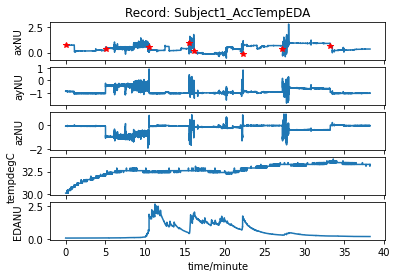

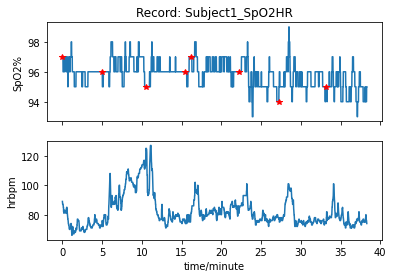

In [161]:
subject_plot(0)

# Data Preprocessing

In this first code block we are putting everything into our 'signals' dict for each subject for ease of access.

In [162]:
for i in tqdm(range(20)):
  sample = all_subjects[i].AccTempEDAAnn.__dict__['sample'] # sample name (for those with 8 per second)
  stages = all_subjects[i].AccTempEDAAnn.__dict__['aux_note'] #stage name
  signals = all_subjects[i].AccTempEDA.__dict__['p_signal'] #signal of those with 8 per sec
  hr_spo2 = all_subjects[i].SpO2HR.__dict__['p_signal'] #signal of one sample per sec
  sample_hr = np.floor(sample/8).astype(int) # change sample to be 1sample per sec instead of 8 per sec
  for j in range(len(stages)):
    if j!=7:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:sample[j+1],0],
                                                 'ay':signals[sample[j]:sample[j+1],1],
                                                 'az':signals[sample[j]:sample[j+1],2],
                                                 'temp':signals[sample[j]:sample[j+1],3],
                                                 'EDA':signals[sample[j]:sample[j+1],4],
                                                 'spo2':hr_spo2[sample_hr[j]:sample_hr[j+1],0],
                                                 'hr':hr_spo2[sample_hr[j]:sample_hr[j+1],1],
                                                 })
    else:
      all_subjects[i].signals[stages[j]].append({'ax':signals[sample[j]:,0],
                                                 'ay':signals[sample[j]:,1],
                                                 'az':signals[sample[j]:,2],
                                                 'temp':signals[sample[j]:,3],
                                                 'EDA':signals[sample[j]:,4],
                                                 'spo2':hr_spo2[sample_hr[j]:,0],
                                                 'hr':hr_spo2[sample_hr[j]:,1],
                                                 })

100%|██████████| 20/20 [00:00<?, ?it/s]


This way we can access the signals for the ax reading of Subject 1 of the Physical Stress stage like so.

In [163]:
all_subjects[0].signals['PhysicalStress'][0]['ax']

array([0.35000214, 0.31001205, 0.29004242, ..., 0.47002319, 0.44004334,
       0.31001205])

In [164]:
var = ['ax','ay','az','EDA','temp','spo2','hr']
minimum_values_accEDA = {'Relax':2384,'PhysicalStress':2593,'EmotionalStress':320,'CognitiveStress':2769}
minimum_values_sp02hr = {'Relax':298,'PhysicalStress':298,'EmotionalStress':40,'CognitiveStress':298}
ite = [4,1,2,1] # number of times a stage is repeated (i.e. there are four relaxed stages)
types = ['Relax','PhysicalStress','EmotionalStress', 'CognitiveStress']

In this codeblock, we are making the signals for all subjects the same size. We first looked for the minimum values for the signals then we reshaped the rest to the minimum.

In [165]:
for i in tqdm(range(20)): # loop over subjects
    for k in range(4): # identify which state you're in
      for w in range(ite[k]): # the number of times we will loop for each state
        for v in var: # loop over all variables
          if v in ['spo2','hr']: # if in spo2/hr then use the min values for those
              minimum = minimum_values_sp02hr[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))
          else: # else use the min values for the others
              minimum = minimum_values_accEDA[types[k]]
              all_subjects[i].signals[types[k]][w][v] = np.resize(all_subjects[i].signals[types[k]][w][v],new_shape=(minimum,))

100%|██████████| 20/20 [00:00<00:00, 592.25it/s]


In [166]:
df = pd.DataFrame(columns=['vector','subject','stage','label'])
df = df.astype({'subject':int,'stage':str,'label':int})

## Feature Vector
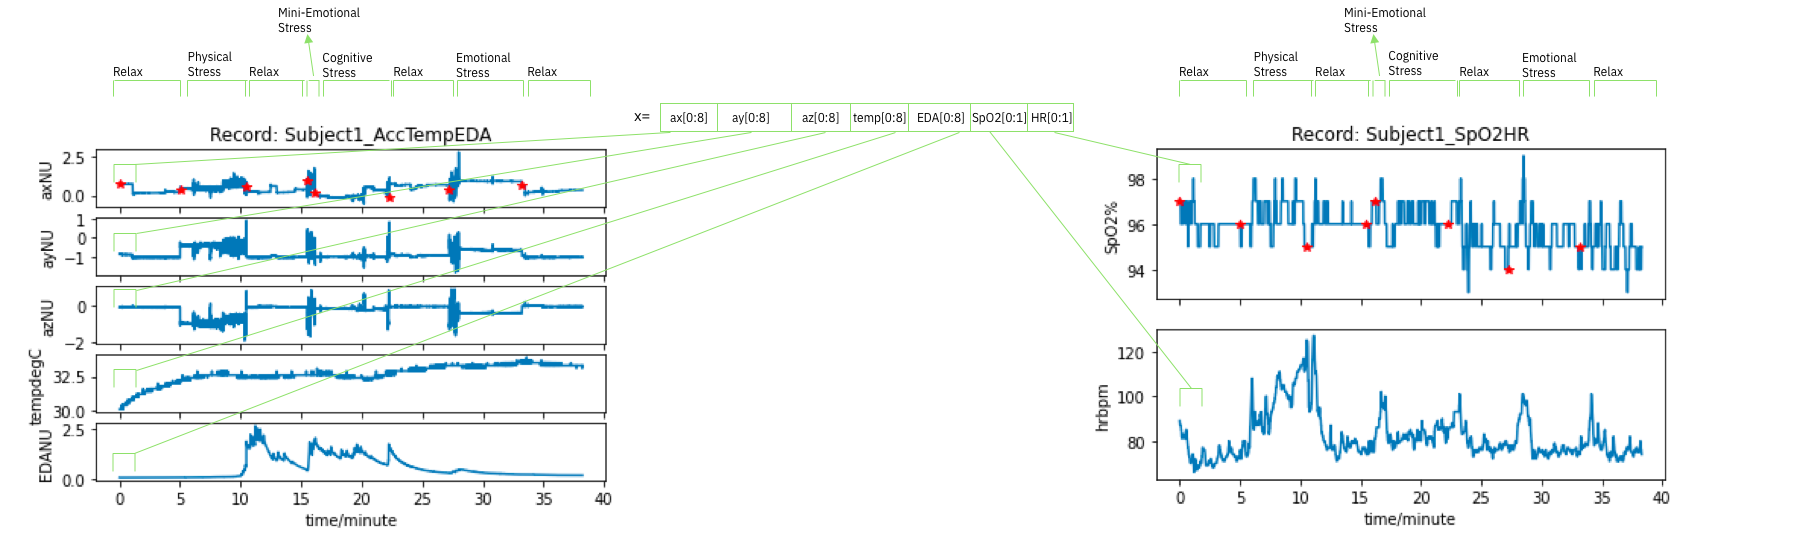

Here we are splitting the signal for each subject into multiple observations. We do this by taking 8 sample from ax, ay, ax, temp, and EDA and 1 sample from SpO2 and HR. We then concatenate all these into one single vector to represent one obervation. The dimension of the vector is 42, 8 values from ax, ay, az, temp, and EDA, which is 40 in total plus 1 observation from SpO2 and one from HR. This is done for all subjects and all stages. The value eta is tunable. For example, if we make eta=16 then we will take 16 observations from from ax, ay, ax, temp, and EDA and 2 sample from SpO2 and HR.

**Note: The first readings (i.e. ax, ay, az, temp, EDA) are 8 samples/s while the second readings (i.e. SpO2 and HR) are 1 sample/s therefore we always take 8 times the number of samples from the first reading compared to the second reading.**

In [ ]:
eta = 8
X_list = []  
y_list = []  
rows = []    

size1 = int(eta)
size2 = int(size1 / 8)

for person in tqdm(range(20)):  
    for k in range(4): 
        idx1 = int(minimum_values_accEDA[types[k]] / size1)
        idx2 = int(minimum_values_sp02hr[types[k]] / size2)
        for i in range(min(idx1, idx2)):
            for j in range(ite[k]):  # Loop over types
                # Concatenate signals
                x = np.concatenate([
                    all_subjects[person].signals[types[k]][j]['ax'][size1 * i:(i + 1) * size1],
                    all_subjects[person].signals[types[k]][j]['ay'][size1 * i:(i + 1) * size1],
                    all_subjects[person].signals[types[k]][j]['az'][size1 * i:(i + 1) * size1],
                    all_subjects[person].signals[types[k]][j]['EDA'][size1 * i:(i + 1) * size1],
                    all_subjects[person].signals[types[k]][j]['temp'][size1 * i:(i + 1) * size1],
                    all_subjects[person].signals[types[k]][j]['spo2'][size2 * i:(i + 1) * size2],
                    all_subjects[person].signals[types[k]][j]['hr'][size2 * i:(i + 1) * size2]
                ])
                
                # Append to X and y lists
                X_list.append(x)
                y_list.append(k)
                
                # Append row for DataFrame
                rows.append({'vector': x, 'subject': int(person + 1), 'stage': types[k], 'label': k})

# Convert lists to numpy arrays
X = np.array(X_list, dtype=object)  
y = np.array(y_list)

# Create DataFrame
df = pd.DataFrame(rows)

100%|██████████| 20/20 [00:00<00:00, 59.99it/s]


In [168]:
X = X.reshape(37360,42)

In [169]:
df['stage'].unique()

array(['Relax', 'PhysicalStress', 'EmotionalStress', 'CognitiveStress'],
      dtype=object)

In [170]:
df['subject'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [171]:
df['stage'].unique()

array(['Relax', 'PhysicalStress', 'EmotionalStress', 'CognitiveStress'],
      dtype=object)

In [172]:
df.head(7)

,vector,subject,stage,label
0,"[0.7700250251769831, 0.7500045777756547, 0.770...",1,Relax,0
1,"[0.5200234992517648, 0.6300343333225163, 0.470...",1,Relax,0
2,"[-0.1399906918544667, 0.030030671101992677, -0...",1,Relax,0
3,"[0.6000036622205237, 0.6100138859211879, 0.600...",1,Relax,0
4,"[0.7600148014763188, 0.7600148014763188, 0.760...",1,Relax,0
5,"[0.2600117496258824, 0.460012970366057, 0.5200...",1,Relax,0
6,"[0.4200228888816776, 0.4500027466653928, 0.600...",1,Relax,0


# Modeling

## Dimensionality Reduction

In [173]:
from sklearn.preprocessing import StandardScaler

In [174]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [175]:
from sklearn.decomposition import PCA

In [176]:
pca = PCA(n_components=11)
pca.fit(scaled_X)

PCA(n_components=11)

We chose to take the first 11 principal components since they account for more than 99% of the variance in the data.

In [177]:
explained_variance_ratios = pca.explained_variance_ratio_ # obtain explained variance ratios in descending order
cumulative_sum = np.cumsum(explained_variance_ratios) # compute the cumulative sum
cumulative_sum

array([0.2759892 , 0.53905049, 0.72470378, 0.84839492, 0.94131126,
       0.96528221, 0.98309351, 0.98641274, 0.98813135, 0.98970479,
       0.99100384])

In [178]:
PC = pca.transform(scaled_X)

In [179]:
PC.shape

(37360, 11)

In [180]:
import pickle

with open('PCA_MODEL.pkl', 'wb') as f:
    pickle.dump(pca, f)
    

print("Model saved as 'PCA_MODEL.pkl'")

Model saved as 'PCA_MODEL.pkl'


It's a Classification problem, thus we'd try modelling our data with different types of classifiers

# Multilayer Perceptron

In [181]:
EVAL_SCORES=pd.DataFrame(columns=['Model','Cross-Validation','Leave-one out','PCA','Accuracy'])
EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy


### Cross-validation Per Subject

In this codeblock, we train a model for each subject by splitting it into 80% train and 20% test. We then compute the accuracy for each subjects model. We apply this same procedure for kNN and Random Forest.

In [182]:
LOO_accuracy_subject_mlp = pd.DataFrame(columns=['subject','accuracy'])
LOO_accuracy_subject_mlp = LOO_accuracy_subject_mlp.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test_mlp = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  mlp_subject = MLPClassifier(max_iter=500,hidden_layer_sizes=(40,20,),learning_rate_init=0.001,activation='relu')
  mlp_subject.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject_mlp = mlp_subject.predict(PC_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject_mlp,y_subject_test_mlp)}])
  LOO_accuracy_subject_mlp= pd.concat([LOO_accuracy_subject_mlp,new_row],ignore_index = True)

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


In [183]:
LOO_accuracy_subject_mlp.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.0,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.00000
accuracy,0.983957,0.981283,0.994652,0.991979,0.989305,0.973262,0.994652,0.989305,0.983957,0.983957,0.983957,0.994652,1.0,0.994652,0.989305,0.994652,0.991979,0.981283,0.994652,0.97861


In [184]:
mean_acc = np.mean(LOO_accuracy_subject_mlp['accuracy'])*100
print('Mean accuracy: %.3f'%mean_acc,'%')

Mean accuracy: 98.850 %


In [185]:
new_row = pd.DataFrame([{
    'Model': 'Multi-Layer Perceptron',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

C:\Users\sama amr\AppData\Local\Temp\ipykernel_44428\3874284053.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267


### Leave One Subject Out Validation

In this codeblock, we remove one subject from the data and train the model using the rest of the subjects. We then test the model on the subject we removed from the training data. We apply the same procedure for kNN and Random Forest.

In [186]:
LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
LOO_accuracy = LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  mlp_loo = MLPClassifier(max_iter=500,hidden_layer_sizes=(40,20,),learning_rate_init=0.001,activation='relu')
  mlp_loo.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = mlp_loo.predict(LOO_X_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}])
  LOO_accuracy= pd.concat([LOO_accuracy,new_row],ignore_index = True)

100%|██████████| 20/20 [08:22<00:00, 25.14s/it]


In [187]:
LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.413812,0.511777,0.930942,0.792291,0.540685,0.668094,0.816916,0.714133,0.799251,0.593148,0.827088,0.576017,0.817452,0.781585,0.809422,0.682013,0.462527,0.882227,0.326552,0.568522


In [188]:
mean_acc = np.mean(LOO_accuracy['accuracy']) * 100
print('Mean accuracy: %.2f'%mean_acc, "%")

Mean accuracy: 67.57 %


In [189]:
new_row = pd.DataFrame([{
    'Model': 'Multi-Layer Perceptron',
    'Cross-Validation': '--',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270


### Without PCA

In [190]:
LOO_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
LOO_accuracy_subject = LOO_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  X_subject = X[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
  
  mlp_subject = MLPClassifier(max_iter=500,hidden_layer_sizes=(40,20,),learning_rate_init=0.001,activation='relu')
  mlp_subject.fit(X_subject_train, y_subject_train)
  y_hat_loo = mlp_subject.predict(X_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,y_subject_test)}])
  LOO_accuracy_subject= pd.concat([LOO_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


In [191]:
LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.413812,0.511777,0.930942,0.792291,0.540685,0.668094,0.816916,0.714133,0.799251,0.593148,0.827088,0.576017,0.817452,0.781585,0.809422,0.682013,0.462527,0.882227,0.326552,0.568522


In [192]:
mean_acc = np.mean(LOO_accuracy['accuracy']) * 100
print('Mean accuracy: %.2f'%mean_acc, "%")

Mean accuracy: 67.57 %


In [193]:
new_row = pd.DataFrame([{
    'Model': 'Multi-Layer Perceptron',
    'Cross-Validation': 'Yes',
    'Leave-one out': '--',
    'PCA': 'NO',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270


# KNN

### Cross-validation Per Subject

In [194]:
KNN_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
KNN_accuracy_subject = KNN_accuracy_subject.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  knn = KNeighborsClassifier(n_neighbors=50)
  knn.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = knn.predict(PC_subject_test)
    
  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  KNN_accuracy_subject= pd.concat([KNN_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 46.48it/s]


In [195]:
KNN_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.00000,9.000000,10.000000,11.00000,12.000000,13.00000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.946524,0.946524,0.973262,0.914439,0.954545,0.882353,0.951872,0.94385,0.951872,0.933155,0.94385,0.930481,0.92246,0.949198,0.927807,0.938503,0.946524,0.930481,0.927807,0.919786


In [196]:
mean_acc = np.mean(KNN_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc, '%')

Mean accuracy: 93.68 %


In [197]:
new_row = pd.DataFrame([{
    'Model': 'KNN',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471


##### Leave One Subject Out Validation

In [198]:
KNN_LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
KNN_LOO_accuracy = KNN_LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  knn = KNeighborsClassifier(n_neighbors=50)
  knn.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = knn.predict(LOO_X_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}])
  KNN_LOO_accuracy= pd.concat([KNN_LOO_accuracy,new_row],ignore_index = True)

100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


In [199]:
KNN_LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.00000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.622056,0.721092,0.913812,0.81531,0.752677,0.786403,0.612955,0.801927,0.789615,0.798715,0.796574,0.607066,0.669165,0.802463,0.788544,0.589936,0.425589,0.807281,0.571199,0.650964


In [200]:
mean_acc = np.mean(KNN_LOO_accuracy['accuracy']) * 100
print('Mean accuracy: %.2f'%mean_acc, '%')

Mean accuracy: 71.62 %


In [201]:
new_row = pd.DataFrame([{
    'Model': 'KNN',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702


### Without PCA

In [202]:
KNN_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
KNN_accuracy_subject = KNN_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  X_subject = X[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
  
  knn = KNeighborsClassifier(n_neighbors=50)
  knn.fit(X_subject_train, y_subject_train)
  y_hat_loo_subject = knn.predict(X_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  KNN_accuracy_subject= pd.concat([KNN_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 32.37it/s]


In [203]:
KNN_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.00000,3.000000,4.000000,5.00000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.00000,14.00000,15.00000,16.000000,17.000000,18.000000,19.000000,20.00000
accuracy,0.885027,0.90107,0.970588,0.906417,0.90107,0.852941,0.951872,0.930481,0.895722,0.938503,0.906417,0.946524,0.90107,0.94385,0.86631,0.938503,0.925134,0.879679,0.911765,0.94385


In [204]:
mean_acc = np.mean(KNN_accuracy_subject['accuracy']) * 100
print('Mean accuracy: %.2f'%mean_acc, '%')

Mean accuracy: 91.48 %


In [205]:
new_row = pd.DataFrame([{
    'Model': 'KNN',
    'Cross-Validation': 'Yes',
    'Leave-one out': '--',
    'PCA': 'NO',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957


# Random Forests

### Cross-validation Per Subject

In [206]:
RF_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
RF_accuracy_subject = RF_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = clf.predict(PC_subject_test)
  
  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  RF_accuracy_subject= pd.concat([RF_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


In [207]:
RF_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.986631,0.983957,0.994652,0.991979,0.991979,0.970588,0.994652,0.970588,0.991979,0.991979,0.997326,0.991979,0.991979,0.989305,0.994652,0.994652,0.983957,0.973262,0.989305,0.973262


In [208]:
mean_acc = np.mean(RF_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc,'%')

Mean accuracy: 98.74 %


In [209]:
new_row = pd.DataFrame([{
    'Model': 'Random Forest',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316


### Leave One Subject Out Validation

In [210]:
RF_all_subjects = pd.DataFrame(columns=['subject','accuracy'])
RF_all_subjects = RF_all_subjects.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = clf.predict(LOO_X_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}])
  RF_all_subjects= pd.concat([RF_all_subjects,new_row],ignore_index = True)

100%|██████████| 20/20 [04:39<00:00, 13.97s/it]


In [211]:
RF_all_subjects.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.00000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.00000,13.00000,14.00000,15.000000,16.000000,17.000000,18.000000,19.00000,20.000000
accuracy,0.70182,0.705567,0.91863,0.858672,0.770343,0.786403,0.915418,0.796574,0.813169,0.864026,0.808351,0.59636,0.84743,0.79015,0.796039,0.691113,0.455567,0.824946,0.74197,0.619379


In [212]:
mean_acc = np.mean(RF_all_subjects['accuracy'])*100
print('Mean accuracy: %.2f'%mean_acc,'%')

Mean accuracy: 76.51 %


In [213]:
new_row = pd.DataFrame([{
    'Model': 'Random Forest',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636


### Without PCA

In [214]:
RF_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
RF_accuracy_subject = RF_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  X_subject = X[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
  
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(X_subject_train, y_subject_train)
  y_hat_loo_subject = clf.predict(X_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  RF_accuracy_subject= pd.concat([RF_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


In [215]:
RF_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.0,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.0,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.983957,0.994652,0.997326,0.994652,1.0,0.986631,0.986631,0.989305,0.994652,0.991979,0.986631,0.994652,1.0,0.994652,0.989305,0.994652,0.981283,0.983957,0.994652,0.983957


In [216]:
mean_acc = np.mean(RF_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc,'%')

Mean accuracy: 99.12 %


In [217]:
new_row = pd.DataFrame([{
    'Model': 'Random Forest',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'NO',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647


### Important Feature

In [218]:
def check_integer_section(value):
    idx = value

    # Check the sections
    if idx < 8:
        return "Value Related to ax"
    elif 8 <= idx < 16:
        return "Value Related to ay"
    elif 16 <= idx < 24:
        return "Value Related to az"
    elif 24 <= idx < 32 :
        return "Value Related to temp"
    elif 32 <= idx < 40 :
        return "Value Related to EDA"
    elif 40 <= idx < 41 :
        return "Value Related to Sp02"
    else:
        return "Value Related to HR"

In [219]:
importances = clf.feature_importances_

# Create a DataFrame for better visualization
feature_names = list(range(1, 43))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Feature', ascending=True)

result = check_integer_section(importances.argmax()+1)
print("Max importance feature: ", importances.argmax()+1, '\nImportance: ', importances.max())
print(result)
importance_df

Max importance feature:  24 
Importance:  0.10432486326774751
Value Related to temp


,Feature,Importance
0,1,0.003680
1,2,0.004885
2,3,0.002282
3,4,0.003965
4,5,0.004382
5,6,0.003879
6,7,0.007145
7,8,0.002522
8,9,0.002442
9,10,0.002778


# Decision Trees

In [220]:
from sklearn.tree import DecisionTreeClassifier

### Cross-Validation

In [221]:
DT_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
DT_accuracy_subject = DT_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  DT = DecisionTreeClassifier(max_depth=3,criterion='entropy',random_state=42)
  DT.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = DT.predict(PC_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  DT_accuracy_subject= pd.concat([DT_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 77.30it/s]


In [222]:
DT_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.00000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.967914,0.94385,0.994652,0.933155,0.959893,0.850267,0.991979,0.959893,0.893048,0.973262,0.946524,0.954545,0.909091,0.917112,0.903743,0.949198,0.930481,0.965241,0.933155,0.909091


In [223]:
mean_acc = np.mean(DT_accuracy_subject['accuracy'])*100
print('Mean accuracy: %.2f'%mean_acc,'%')

Mean accuracy: 93.93 %


In [224]:
new_row = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


### Leave one out

In [225]:
DT_LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
DT_LOO_accuracy = DT_LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  DT = DecisionTreeClassifier(max_depth=3,criterion='entropy',random_state=42)
  DT.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = DT.predict(LOO_X_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}])
  DT_LOO_accuracy= pd.concat([DT_LOO_accuracy,new_row],ignore_index = True)

100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


In [226]:
DT_LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,10.000000,11.000000,12.000000,13.00000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.867773,0.792291,0.777302,0.813704,0.784797,0.671842,0.85439,0.937901,0.746253,0.842612,0.787473,0.752677,0.80621,0.797645,0.749465,0.702355,0.528908,0.795503,0.752141,0.676124


In [227]:
mean_acc = np.mean(DT_LOO_accuracy['accuracy']) * 100
print('Mean accuracy: %.2f'%mean_acc,'%')

Mean accuracy: 77.19 %


In [228]:
new_row = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


### WITHOUT PCA

In [229]:
DT_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
DT_accuracy_subject = DT_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  X_subject = X[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  DT = DecisionTreeClassifier(max_depth=3,criterion='entropy',random_state=42)
  DT.fit(X_subject_train, y_subject_train)
  y_hat_loo_subject = DT.predict(X_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  DT_accuracy_subject= pd.concat([DT_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 66.71it/s]


In [230]:
DT_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.00000,2.000000,3.000000,4.000000,5.00000,6.00000,7.000000,8.000000,9.000000,10.00000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.97861,0.935829,0.994652,0.965241,0.97861,0.94385,0.973262,0.970588,0.909091,0.94385,0.935829,0.970588,0.941176,0.989305,0.965241,0.927807,0.919786,0.965241,0.957219,0.962567


In [231]:
mean_acc = np.mean(DT_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc ,'%' )

Mean accuracy: 95.64 %


In [232]:
new_row = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'NO',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


# Naive Bayes

In [233]:
from sklearn.naive_bayes import GaussianNB

#### Cross-validation

In [234]:
NB_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
NB_accuracy_subject = NB_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  PC_subject = PC[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  NB = GaussianNB()
  NB.fit(PC_subject_train, y_subject_train)
  y_hat_loo_subject = NB.predict(PC_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  NB_accuracy_subject= pd.concat([NB_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 275.50it/s]


In [235]:
NB_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.00000,3.000000,4.000000,5.000000,6.00000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.941176,0.90107,0.965241,0.909091,0.941176,0.68984,0.909091,0.965241,0.898396,0.957219,0.965241,0.877005,0.860963,0.957219,0.868984,0.914439,0.860963,0.885027,0.957219,0.877005


In [236]:
mean_acc = np.mean(NB_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc ,'%' )

Mean accuracy: 90.51 %


In [237]:
new_row = pd.DataFrame([{
    'Model': 'Naive Bayes',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


#### leave one out

In [238]:
NB_LOO_accuracy = pd.DataFrame(columns=['subject','accuracy'])
NB_LOO_accuracy = NB_LOO_accuracy.astype({'subject':int,'accuracy':float})

for i in tqdm(range(20)):
  LOO_X_train = PC[df['subject']!=(i+1)]
  LOO_y_train = y[df['subject']!=(i+1)]
  LOO_X_test = PC[df['subject']==(i+1)]
  LOO_y_test = y[df['subject']==(i+1)]
  NB = GaussianNB()
  NB.fit(LOO_X_train, LOO_y_train)
  y_hat_loo = NB.predict(LOO_X_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo,LOO_y_test)}])
  NB_LOO_accuracy= pd.concat([NB_LOO_accuracy,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 73.08it/s]


In [239]:
NB_LOO_accuracy.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.743576,0.779443,0.743576,0.763383,0.440043,0.740364,0.692184,0.799786,0.77409,0.728587,0.774625,0.681478,0.774625,0.808351,0.759101,0.648822,0.639186,0.766595,0.755353,0.692184


In [240]:
mean_acc = np.mean(NB_LOO_accuracy['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc ,'%' )

Mean accuracy: 72.53 %


In [241]:
new_row = pd.DataFrame([{
    'Model': 'Naive Bayes',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


#### WITHOUT PCA

In [242]:
NB_accuracy_subject = pd.DataFrame(columns=['subject','accuracy'])
NB_accuracy_subject = NB_accuracy_subject.astype({'subject':int,'accuracy':float})
for i in tqdm(range(20)):
  X_subject = X[df['subject']==(i+1)]
  y_subject = y[df['subject']==(i+1)]
  X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
  #Create a Gaussian Classifier
  NB = GaussianNB()
  NB.fit(X_subject_train, y_subject_train)
  y_hat_loo_subject = NB.predict(X_subject_test)

  new_row=pd.DataFrame([{'subject': i+1,'accuracy':accuracy_score(y_hat_loo_subject,y_subject_test)}])
  NB_accuracy_subject= pd.concat([NB_accuracy_subject,new_row],ignore_index = True)

100%|██████████| 20/20 [00:00<00:00, 146.16it/s]


In [243]:
NB_accuracy_subject.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
subject,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
accuracy,0.919786,0.842246,0.970588,0.874332,0.946524,0.879679,0.970588,0.970588,0.967914,0.975936,0.975936,0.962567,0.799465,0.983957,0.927807,0.925134,0.700535,0.951872,0.954545,0.852941


In [244]:
mean_acc = np.mean(NB_accuracy_subject['accuracy']) *100
print('Mean accuracy: %.2f'%mean_acc ,'%' )

Mean accuracy: 91.76 %


In [245]:
new_row = pd.DataFrame([{
    'Model': 'Naive Bayes',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'No',
    'Accuracy':mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES

,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


# FLDA

In [246]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import numpy as np

### Cross Validation

In [247]:
# Cross Validation
FLDA_accuracy_subject = pd.DataFrame(columns=['subject', 'accuracy'])
FLDA_accuracy_subject = FLDA_accuracy_subject.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    PC_subject = PC[df['subject'] == (i + 1)]
    y_subject = y[df['subject'] == (i + 1)]
    PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(PC_subject, y_subject, test_size=0.2, random_state=42)
    
    # Create FLDA model
    flda = LDA()
    flda.fit(PC_subject_train, y_subject_train)
    y_hat_loo_subject = flda.predict(PC_subject_test)
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat_loo_subject, y_subject_test)}])
    FLDA_accuracy_subject = pd.concat([FLDA_accuracy_subject, new_row], ignore_index=True)

FLDA_accuracy_subject.T
mean_acc = np.mean(FLDA_accuracy_subject['accuracy']) * 100
print('Mean accuracy: %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'FLDA',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy': mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)
EVAL_SCORES

100%|██████████| 20/20 [00:00<00:00, 166.57it/s]

Mean accuracy: 91.86 %


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


### Leave One Out

In [248]:
FLDA_LOO_accuracy = pd.DataFrame(columns=['subject', 'accuracy'])
FLDA_LOO_accuracy = FLDA_LOO_accuracy.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    LOO_X_train = PC[df['subject'] != (i + 1)]
    LOO_y_train = y[df['subject'] != (i + 1)]
    LOO_X_test = PC[df['subject'] == (i + 1)]
    LOO_y_test = y[df['subject'] == (i + 1)]
    
    # FLDA Model
    flda = LDA()
    flda.fit(LOO_X_train, LOO_y_train)
    y_hat_loo = flda.predict(LOO_X_test)
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat_loo, LOO_y_test)}])
    FLDA_LOO_accuracy = pd.concat([FLDA_LOO_accuracy, new_row], ignore_index=True)

FLDA_LOO_accuracy.T
mean_acc = np.mean(FLDA_LOO_accuracy['accuracy']) * 100
print('Mean accuracy: %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'FLDA',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy': mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)
EVAL_SCORES


100%|██████████| 20/20 [00:00<00:00, 30.15it/s]

Mean accuracy: 77.24 %


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.850267
1,Multi-Layer Perceptron,--,Yes,Yes,67.572270
2,Multi-Layer Perceptron,Yes,--,NO,67.572270
3,KNN,Yes,---,Yes,93.676471
4,KNN,---,Yes,Yes,71.616702
5,KNN,Yes,--,NO,91.483957
6,Random Forest,Yes,---,Yes,98.743316
7,Random Forest,---,Yes,Yes,76.509636
8,Random Forest,Yes,---,NO,99.117647
9,Decision Tree,Yes,---,Yes,93.930481


### Without PCA

In [249]:
FLDA_accuracy_subject = pd.DataFrame(columns=['subject', 'accuracy'])
FLDA_accuracy_subject = FLDA_accuracy_subject.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    X_subject = X[df['subject']==(i+1)]
    y_subject = y[df['subject']==(i+1)]
    X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(X_subject, y_subject, test_size=0.2, random_state=42)
    
    # FLDA Model
    flda = LDA()
    flda.fit(X_subject_train, y_subject_train)
    y_hat_loo_subject = flda.predict(X_subject_test)
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat_loo_subject, y_subject_test)}])
    FLDA_accuracy_subject = pd.concat([FLDA_accuracy_subject, new_row], ignore_index=True)

FLDA_accuracy_subject.T
mean_acc = np.mean(FLDA_accuracy_subject['accuracy']) * 100
print('Mean accuracy: %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'FLDA',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'No',
    'Accuracy': mean_acc
}])

# Concatenate the new row with the existing DataFrame
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

EVAL_SCORES['Accuracy'] = pd.to_numeric(EVAL_SCORES['Accuracy'], errors='coerce').fillna(0).round(2)
EVAL_SCORES

100%|██████████| 20/20 [00:00<00:00, 44.55it/s]

Mean accuracy: 91.89 %


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.85
1,Multi-Layer Perceptron,--,Yes,Yes,67.57
2,Multi-Layer Perceptron,Yes,--,NO,67.57
3,KNN,Yes,---,Yes,93.68
4,KNN,---,Yes,Yes,71.62
5,KNN,Yes,--,NO,91.48
6,Random Forest,Yes,---,Yes,98.74
7,Random Forest,---,Yes,Yes,76.51
8,Random Forest,Yes,---,NO,99.12
9,Decision Tree,Yes,---,Yes,93.93


# Least Squares

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

### Cross-Validation with PCA

In [251]:
LS_accuracy_subject = pd.DataFrame(columns=['subject', 'accuracy'])
LS_accuracy_subject = LS_accuracy_subject.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    PC_subject = PC[df['subject'] == (i + 1)]
    y_subject = y[df['subject'] == (i + 1)]
    PC_subject_train, PC_subject_test, y_subject_train, y_subject_test = train_test_split(
        PC_subject, y_subject, test_size=0.2, random_state=42
    )
    
    # Least Squares Model using Ridge Regression (α=0 to mimic LS)
    ls_model = Ridge(alpha=0)
    ls_model.fit(PC_subject_train, y_subject_train)
    y_hat = np.round(ls_model.predict(PC_subject_test))  # Round predictions for classification
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat, y_subject_test)}])
    LS_accuracy_subject = pd.concat([LS_accuracy_subject, new_row], ignore_index=True)

mean_acc = np.mean(LS_accuracy_subject['accuracy']) * 100
print('Mean accuracy (CV, PCA): %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'LS',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'Yes',
    'Accuracy': mean_acc
}])
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)


100%|██████████| 20/20 [00:00<00:00, 157.53it/s]

Mean accuracy (CV, PCA): 64.33 %


### Leave-One-Out Validation

In [252]:
LS_LOO_accuracy = pd.DataFrame(columns=['subject', 'accuracy'])
LS_LOO_accuracy = LS_LOO_accuracy.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    LOO_X_train = PC[df['subject'] != (i + 1)]
    LOO_y_train = y[df['subject'] != (i + 1)]
    LOO_X_test = PC[df['subject'] == (i + 1)]
    LOO_y_test = y[df['subject'] == (i + 1)]
    
    ls_model = Ridge(alpha=0)
    ls_model.fit(LOO_X_train, LOO_y_train)
    y_hat = np.round(ls_model.predict(LOO_X_test))
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat, LOO_y_test)}])
    LS_LOO_accuracy = pd.concat([LS_LOO_accuracy, new_row], ignore_index=True)

mean_acc = np.mean(LS_LOO_accuracy['accuracy']) * 100
print('Mean accuracy (LOO, PCA): %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'LS',
    'Cross-Validation': '---',
    'Leave-one out': 'Yes',
    'PCA': 'Yes',
    'Accuracy': mean_acc
}])
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)


100%|██████████| 20/20 [00:00<00:00, 104.40it/s]

Mean accuracy (LOO, PCA): 41.71 %


### Cross-Validation without PCA

In [253]:
LS_accuracy_subject = pd.DataFrame(columns=['subject', 'accuracy'])
LS_accuracy_subject = LS_accuracy_subject.astype({'subject': int, 'accuracy': float})

for i in tqdm(range(20)):
    X_subject = X[df['subject'] == (i + 1)]
    y_subject = y[df['subject'] == (i + 1)]
    X_subject_train, X_subject_test, y_subject_train, y_subject_test = train_test_split(
        X_subject, y_subject, test_size=0.2, random_state=42
    )
    
    ls_model = Ridge(alpha=0)
    ls_model.fit(X_subject_train, y_subject_train)
    y_hat = np.round(ls_model.predict(X_subject_test))
    
    new_row = pd.DataFrame([{'subject': i + 1, 'accuracy': accuracy_score(y_hat, y_subject_test)}])
    LS_accuracy_subject = pd.concat([LS_accuracy_subject, new_row], ignore_index=True)

mean_acc = np.mean(LS_accuracy_subject['accuracy']) * 100
print('Mean accuracy (CV, no PCA): %.2f' % mean_acc, '%')

new_row = pd.DataFrame([{
    'Model': 'LS',
    'Cross-Validation': 'Yes',
    'Leave-one out': '---',
    'PCA': 'No',
    'Accuracy': mean_acc
}])
EVAL_SCORES = pd.concat([EVAL_SCORES, new_row], ignore_index=True)

# Finalize and display results
EVAL_SCORES['Accuracy'] = pd.to_numeric(EVAL_SCORES['Accuracy'], errors='coerce').fillna(0).round(2)
EVAL_SCORES

100%|██████████| 20/20 [00:00<00:00, 127.85it/s]

Mean accuracy (CV, no PCA): 64.28 %


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.85
1,Multi-Layer Perceptron,--,Yes,Yes,67.57
2,Multi-Layer Perceptron,Yes,--,NO,67.57
3,KNN,Yes,---,Yes,93.68
4,KNN,---,Yes,Yes,71.62
5,KNN,Yes,--,NO,91.48
6,Random Forest,Yes,---,Yes,98.74
7,Random Forest,---,Yes,Yes,76.51
8,Random Forest,Yes,---,NO,99.12
9,Decision Tree,Yes,---,Yes,93.93


In [254]:
EVAL_SCORES['Accuracy']=round(EVAL_SCORES['Accuracy'],2)

# Evaluation Summary

In [255]:
print('Model with the Max Accuracy: ',EVAL_SCORES['Model'][EVAL_SCORES['Accuracy'].argmax()] ,'\nAccuracy: ',EVAL_SCORES['Accuracy'].max())
EVAL_SCORES

Model with the Max Accuracy:  Random Forest 
Accuracy:  99.12


,Model,Cross-Validation,Leave-one out,PCA,Accuracy
0,Multi-Layer Perceptron,Yes,---,Yes,98.85
1,Multi-Layer Perceptron,--,Yes,Yes,67.57
2,Multi-Layer Perceptron,Yes,--,NO,67.57
3,KNN,Yes,---,Yes,93.68
4,KNN,---,Yes,Yes,71.62
5,KNN,Yes,--,NO,91.48
6,Random Forest,Yes,---,Yes,98.74
7,Random Forest,---,Yes,Yes,76.51
8,Random Forest,Yes,---,NO,99.12
9,Decision Tree,Yes,---,Yes,93.93


# GUI

In [256]:
import pickle

with open('RF_trained_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

#Model= pickle.dumps(mlp_subject)

print("Model saved as 'RF_trained_model.pkl'")

Model saved as 'RF_trained_model.pkl'


In [264]:
from tkinter import *
import random
import pickle
import pandas as pd
import numpy as np
from tkinter import messagebox

with open('RF_trained_model.pkl', 'rb') as file:
    Model = pickle.load(file)

with open('PCA_MODEL.pkl', 'rb') as file:
    Model_PCA = pickle.load(file) 

# GUI Window Configuration
window = Tk()
window.rowconfigure(0, weight=1)
window.columnconfigure(0, weight=1)
window.state('zoomed')

page1 = Frame(window)
page2 = Frame(window)

for frame in (page1, page2):
    frame.grid(row=0, column=0, sticky='nsew')

def show_frame(frame):
    frame.tkraise()

show_frame(page1)

# ============= Page 1 ============
canvas = Canvas(
    page1,
    bg="#FFFFFF",
    height=982,
    width=1512,
    bd=0,
    highlightthickness=0,
    relief="ridge"
)
canvas.place(x=0, y=0)
canvas.create_rectangle(
    0.0,
    0.0,
    1512.0,
    123.0,
    fill="#5379a7",
    outline=""
)
canvas.create_text(
    32.0,
    42.0,
    anchor="nw",
    text="Neurological Status Prediction",
    fill="#FFFFFF",
    font=("Junge Regular", 50 * -1)
)

# Input field for patient number
patient_number_var = StringVar()
patient_label = Label(
    page1,
    text="Enter Patient Number:",
    font=("Montserrat Medium", 16),
    bg="#FFFFFF",
    fg="#000000"
)
patient_label.place(x=250, y=270)

patient_entry = Entry(
    page1,
    textvariable=patient_number_var,
    font=("Montserrat Medium", 16),
    width=60
)
patient_entry.place(x=250, y=320)

# Mapping dictionary
label_mapping = {
    0: 'Relax',
    1: 'PhysicalStress',
    2: 'EmotionalStress',
    3: 'CognitiveStress'
}


def predict_for_patient():
    try:
        # Get the patient number from the input field
        patient_number = int(patient_number_var.get())
        
        # Filter the DataFrame for the specified patient
        patient_data = df[df["subject"] == patient_number]
        
        if patient_data.empty:
            raise ValueError(f"No data found for patient number {patient_number}.")
        
        rand_int_vec = random.randrange(1, 1868, 1)

        # Get the 'vector' for the specific patient and random row
        DF = df[df['subject'] == patient_number].iloc[rand_int_vec]['vector']

        # Parse the vector and perform prediction
        vector = np.array(DF).reshape(1, -1)
        prediction = Model.predict(vector) 

        # Map the prediction value to the corresponding label
        label_mapping = {
            0: 'Relax',
            1: 'PhysicalStress',
            2: 'EmotionalStress',
            3: 'CognitiveStress'
        }
        predicted_label = label_mapping.get(prediction[0], "Unknown")

        # Get the ground truth label for the patient and random row
        ground_truth_value = df[df['subject'] == patient_number].iloc[rand_int_vec]["label"]
        ground_truth_label = label_mapping.get(ground_truth_value, "Unknown")

        # Show results on Page 2
        result_text.set(f"Prediction: {predicted_label}\n\nGround Truth: {ground_truth_label}")
        show_frame(page2)
        
    except ValueError as ve:
        messagebox.showerror("Input Error", str(ve))
    except Exception as e:
        messagebox.showerror("Error", f"Unexpected error: {e}")


button_2 = Button(
    page1,
    text='Predict',
    font=("Montserrat Medium", int(20.0)),
    borderwidth=0,
    highlightthickness=0,
    command=predict_for_patient,
    relief="flat",
    fg='white',
    bg='#5379a7',
    activebackground='#9ec5f3'
)
button_2.place(
    x=450.0,
    y=450.0,
    width=327.0,
    height=44.0
)

# ============= Page 2 ============
canvas = Canvas(
    page2,
    bg="#FFFFFF",
    height=982,
    width=1512,
    bd=0,
    highlightthickness=0,
    relief="ridge"
)
canvas.place(x=0, y=0)
canvas.create_rectangle(
    0.0,
    0.0,
    1512.0,
    123.0,
    fill="#5379a7",
    outline=""
)
canvas.create_text(
    32.0,
    42.0,
    anchor="nw",
    text="Result",
    fill="#FFFFFF",
    font=("Junge Regular", 50 * -1)
)

result_text = StringVar()
result_label = Label(
    page2,
    textvariable=result_text,
    font=("Montserrat Medium", 20),
    bg="#FFFFFF",
    fg="#000000",
    justify="center"
)
result_label.place(x=400, y=250)

button_3 = Button(
    page2,
    text='Back',
    font=("Montserrat Medium", int(20.0)),
    borderwidth=0,
    highlightthickness=0,
    command=lambda: show_frame(page1),
    relief="flat",
    fg='white',
    bg='#5379a7',
    activebackground='#9ec5f3'
)
button_3.place(
    x=450.0,
    y=450.0,
    width=327.0,
    height=44.0
)

# Run the application
window.mainloop()
